In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import decomposition

In [3]:
# the training arrayCGH data
train_call = pd.read_table('train_call.txt')

# the training class labels
train_clinical = pd.read_table('train_clinical.txt')

# the validation call with unlabeled competition data
validation_call = pd.read_table('validation_call.txt')

In [9]:
# transpose the train call data
df = pd.DataFrame(train_call.T)

# view the dataframe
df

,0,1,2,3,4,5,6,7,8,9,...,2824,2825,2826,2827,2828,2829,2830,2831,2832,2833
Chromosome,1,1,1,1,1,1,1,1,1,1,...,23,23,23,23,23,23,23,23,23,23
Start,2927,85022,370546,471671,792533,912799,1271190,1676445,1738295,2481927,...,151067607,152422390,152552851,152576854,152994680,153062077,153466463,153504394,153938998,153997146
End,43870,216735,372295,786483,907406,1266212,1590570,1703748,2477597,2562342,...,152416606,152548587,152570071,152935130,153054487,153452633,153491568,153933426,153989329,154492924
Nclone,3,4,4,5,13,96,45,4,104,14,...,159,20,6,64,5,57,4,55,5,43
Array.129,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Array.10,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,1
Array.123,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.100,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
Array.134,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


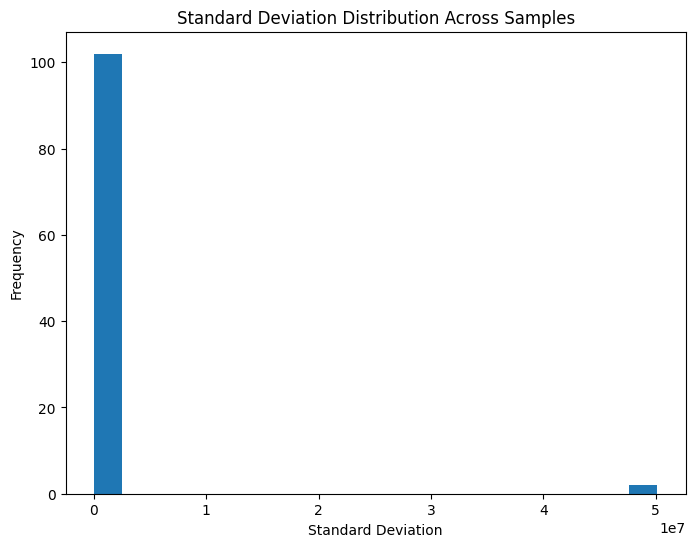

In [5]:
# Calculate standard deviation across probes for each sample
std_dev_per_sample = np.std(df, axis=1)

# Plot the standard deviation distribution
plt.figure(figsize=(8, 6))
plt.hist(std_dev_per_sample, bins=20)
plt.title("Standard Deviation Distribution Across Samples")
plt.xlabel("Standard Deviation")
plt.ylabel("Frequency")
plt.show()

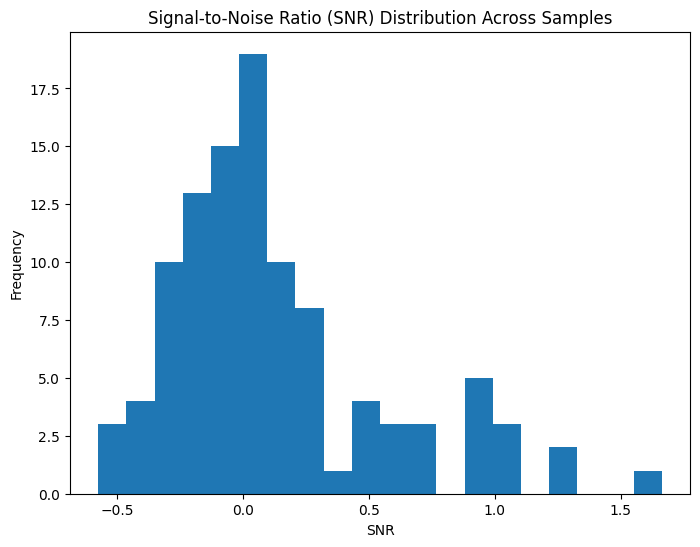

In [6]:
# Calculate signal-to-noise ratio (SNR) for each sample
mean_intensity_per_sample = np.mean(df, axis=1)
snr_per_sample = mean_intensity_per_sample / std_dev_per_sample

# Plot the SNR distribution
plt.figure(figsize=(8, 6))
plt.hist(snr_per_sample, bins=20)
plt.title("Signal-to-Noise Ratio (SNR) Distribution Across Samples")
plt.xlabel("SNR")
plt.ylabel("Frequency")
plt.show()